# Linear Regression - some Theory
* [other compariative exmaples](https://www.analyticsvidhya.com/blog/2017/06/a-comprehensive-guide-for-linear-ridge-and-lasso-regression/)
For linear regression the closed solution is known via the so called normal equation
Todo:
1. Specify model
2. Speficy loss function
2. Write down log Likelihood function
3. Minimize + get Normal equation

### Approach 1: Non-probabilisitc using loss function
The easies approach to linear regression is to use the squared loss function, 
$$l = \sum_{i=1}^N (y_i - \hat y_i)^2,$$
where $\hat y_i$ is the predicted value and $y_i$ is the true value of sample $i$. Together with a linear, non probabilistic model for the. For feature vector $x_i$ (where the first component is per convention the constant one -aka known as intercept) the prediction is given by the linear model. In scalar product notation:
$$y_i =  x_i^T \theta,$$
with coefficient vector $\theta$. Rewriting this in Matrix notation to account for all sampels we get for the loss together with the linear model:
$$l = (Y - X\theta)^T (Y - X\theta)$$
Now we would like to find $\theta^*$ that _minimizes_ the loss. 
Setting the derivative w.r.t. $\theta$ of the loss function zero  gives the normal equation 
$$X^T(Y - X\theta) = 0.$$
If $X^T X$ is non-singular (this is the case when there are more traning examples than features because then $X^T X$ is positive definite) allows for finding the unique solutions of the normal equation, 

$$\theta ^* =  \left( X^T X  \right)^{-1} X^T Y$$

Note that this approach is non-probabilistic and thus, does not explicitly account for uncertainty  (as a probability distributions) in the data and coefficients.
### Approach 2: Probabilistic  +  generative approach using max likelihood
This approach introduces a probability distribution but does not explicitly consider a loss function. The  response is modelled  via a Normal distribution ("Gauss error") assuming constant standard deviation
$$y_i = x_i^T \theta + \epsilon := \mathcal N (x_i^T \theta, \sigma^2)$$
In other words, the conditional distribtion  $p(y \mid x, \theta, \sigma^2)$ is given by a Normal distribtion.
The likelihood function is just the pdf of __all__ datapoints assuming i.i.d (this assumption in fact leads to the factorization), 
$$\mathcal L = \Pi_{i=1}^N p(y_i \mid x, \theta, \sigma).$$
As we are aiming to optimize $\theta$ in a way, a striclty monotonic transformation is applied on the likelihood function. It leaves the optimum invariant. The standard procedure is thus to consider the the logarithm ot likelihood function:
$$\mathcal L_l = \sum_{i=1}^N \log p(y_i \mid x, \theta, \sigma).$$
Evaluating this expression for the Normal distribution gives
$$\mathcal L_l =  - \frac{1}{2\sigma^2}\sum_{i=1}^N (y_i - x_i^T \theta)^2  - \frac{N}{2}log(2\pi\sigma^2) $$
Now, we would like to _maximise_ the likelihood and thus the log likelihood with respect to $\theta$. This is equivalent to _minimizing_ the negative of it. Throwing away terms that, don't depend on $\theta$ gives the function for which we would like to find the minimizer. That is we want to solve this expression, 
$$\text{argmin}_\theta\left( Y - X \theta \right )^T \left( Y - X \theta \right ),$$
where we have rewritten the sum of squares over all training data again in Matrix notation. But this is exactly the same problem as in approach one and this gives the same solution (under the same circumstances), 

$$\theta ^* =  \left( X^T X  \right)^{-1} X^T Y$$

### Idea of this tutorial
- So far we analyitcally derived the log likelihood function
- This gave us the motivation for using the MSE in a purely numeric (tensorflow) world
- Or, the matrix formulation for a purely analytical solution

- Now we directly optimize the log likelihood function
- We aim to learn $\mu$ and $\sigma^2$ of the underlying process, a Gaussian distribuiton

**We want to observe that**
1. If we set $\sigma^2$ to a fixed value, say 1 we will fall back to the original solution in a point estimate sense (that is we estimate y by the learned $\mu$)
2. We can used the learned distribution to get error bars
3. We can also try to learn $\sigma$ assuming it to be a scalar
4. We can also try to learn a heteroscedasticity fashion (that is, dependent of the data)

In [1]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from collections import namedtuple
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
tf.keras.backend.clear_session()

Supervised = namedtuple("supervised", ["features", "target", "feature_names"])

def split_test_train(data):
    X_train, X_test, Y_train, Y_test = train_test_split(data.features, data.target, test_size = 0.2, random_state=5)
    train = Supervised(X_train, Y_train.reshape(-1, 1), feature_names=data.feature_names)
    test = Supervised(X_test, Y_test.reshape(-1, 1), feature_names=data.feature_names)
    return train, test 


def normalize(train: Supervised, test: Supervised):
    mu = train.features.mean(axis=0)
    std = train.features.std(axis=0)
    train_scaled = Supervised(features=(train.features - mu) / std, 
                              target=train.target, 
                              feature_names=train.feature_names) 
    test_scaled = Supervised(features=(test.features - mu) / std, 
                             target=test.target, 
                             feature_names=test.feature_names)
    return train_scaled, test_scaled


housing = fetch_california_housing()
train_data, test_data = normalize(*split_test_train(Supervised(housing.data, housing.target, housing.feature_names)))

# Linear Regression via the Normal equation - with Tensorflow

In [2]:
def add_intercept(features):
    """Add intercept to features
    Todo: as an exercise use tensorflow"""
    m, n = features.shape
    return np.c_[np.ones((m, 1)), features]

    
def train(data):
    X = add_intercept(data.features)
    Y = data.target
    XT = tf.transpose(X)
    return tf.matmul(tf.matmul(tf.linalg.inv(tf.matmul(XT, X)), XT), Y)


def predict(data, theta):
    return tf.matmul( add_intercept(data.features),  theta)

theta_analytic = train(train_data)
y_pred_analytic  = predict(test_data, theta_analytic)

# Linear Regression from directly optimizing the likelihood function
- directly learn the likelihood function instead of using the equivalence to MSE
- in a first step we therefore just learn $\mu = x_i^T \theta$ and fix $\sigma=1$
- So we will directly work with $\mu$ and $\sigma$.
- We wish to maximise the log-likelihood 
- This is equivalent to minimizing the negative log-likelihood


**We will implement the Model as follows:**
1. A Model (`GaussianModel`) that will use custom layers
2. `Gaussian` that will compute the tuple ($\mu$, $\sigma^2$)
3. `Sampling` for later usage in order to compute errors. This is just sampling from the learned Gaussian, wich is specified by the learned ($\mu$, $\sigma^2$)

**Loss function:**
- Training requires the loss function to be the likelihood function. 
- This is implemented in `negative_log_likelihood`

**Training:**
- We write our own training loop 
- The essence is implemented in the function `train_step`
- We could also write a  `call` method in the model and use the keras machinery with an adapted implementation of the negative log liklihood function 

In [3]:
# Model

class Sampling(tf.keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def __init__(self, name="sampling", **kwargs):
        super(Sampling, self).__init__(name=name, **kwargs)
    
    def call(self, params, n_samples):
        mu, var = params
        std = tf.sqrt(var)
        return tf.random.normal([n_samples], mu, std)

        

class Gaussian(tf.keras.layers.Layer):
    
    def __init__(self, out_dim, name="gaussian", **kwargs):
        super(Gaussian, self).__init__(name=name, **kwargs)
        self.layer_mu = tf.keras.layers.Dense(out_dim, activation="linear")
        
    def call(self, inputs):
        # (batch_size, features) -> (batch_size, out_dim)
        mu = self.layer_mu(inputs) 
        # (batch_size, out_dim) for consistency - could also use scalar and rely on broadcasting
        var = tf.ones(mu.shape) 
        return mu, var

    
class GaussModel(tf.keras.Model):

    def __init__(self, out_dim=1,  name="gauss_model", **kwargs):
        super(GaussModel, self).__init__(name=name, **kwargs)
        self.gauss = Gaussian(out_dim)
        self.sampling = Sampling()
        
        
    def encode(self, inputs):
        return  self.gauss(inputs)
    
    def point_estimate(self, inputs):
        mu, var = self.encode(inputs)
        return mu
    
    def sample(self, inputs, n_samples):
        mu, var = self.encode(inputs)
        return self.sampling((mu, var), n_samples)
        

        
# Loss function

def negative_log_likelihood(mu, var, y_true):
    """Loss function 
    Need to carry over varance under the sum for the case of heteroscedasticity"""
    y = tf.cast(y_true, tf.float32)
    a = 0.5 *  tf.math.reduce_sum(tf.math.log(2. * np.pi * var)) 
    b =   tf.math.reduce_sum((y - mu)**2. / (2. * var))
    nll =  a + b
    return nll

In [4]:
# Training

optimizer = tf.keras.optimizers.Adam()
batch_size=16
gauss_model = GaussModel()


@tf.function
def train_step(model, x, y):
    with tf.GradientTape() as tape:
        mu, var = model.encode(x)
        loss = negative_log_likelihood(mu, var, y)
    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    return loss



epochs = 10000
for epoch in range(epochs):
    loss_value = train_step(gauss_model, train_data.features, train_data.target)
    if epoch % 500 == 0:
        print(f"Epoch {epoch}, negative log likelihood {loss_value.numpy()}")
        


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 0, negative log likelihood 80399.6953125
Epoch 500, negative log likelihood 45958.63671875
Epoch 1000, negative log likelihood 32941.38671875
Epoch 1500, negative log likelihood 26033.99609375
Epoch 2000, negative log likelihood 22258.091796875
Epoch 2500, negative log likelihood 20446.71484375
Epoch 3000, negative log likelihood 19743.3828125
Epoch 3500, negative log likelihood 19536.193359375
Epoch 4000, negative log likelihood 19490.580078125
Epoch 4500, negative log likelihood 19481.529296875


### Excursion: an alternative, yet equivalent training procedure
- Cool, we have trained our model using the (negative log) likelihood function as loss function. 
- But note we have already implemented the `point_estimate` method in our model that returns $\mu$ of the gaussian as prediction. 
- Thus we could also use that point estimate and use as loss function the MSE for training. 
- Let's see if this is really true. 

We just neet to adapt the `training_step` method
1. Use the `point_estimate` output of the model
2. Use the MSE as Loss function

In [5]:
import time
optimizer = tf.keras.optimizers.Adam()
mse = tf.keras.losses.MeanSquaredError()
batch_size=16
gauss_model_point_estimate = GaussModel()


@tf.function
def train_step_point_estimate(model, x, y):
    with tf.GradientTape() as tape:
        y_pred = model.point_estimate(x)
        loss = mse(y_pred, y)
    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    return loss


epochs = 10000
for epoch in range(epochs):
    loss_value = train_step_point_estimate(gauss_model_point_estimate, train_data.features, train_data.target)
    if epoch % 500 == 0:
        print(f"Epoch {epoch}, negative log likelihood {loss_value.numpy()}")


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 0, negative log likelihood 8.401113510131836
Epoch 500, negative log likelihood 3.826735734939575
Epoch 1000, negative log likelihood 2.1066677570343018
Epoch 1500, negative log likelihood 1.3091576099395752
Epoch 2000, negative log likelihood 0.8886612057685852
Epoch 2500, negative log likelihood 0.6826648712158203
Epoch 3000, negative log likelihood 0.596088171005249
Epoch 3500, negative log likelihood 0.5630912184715271
Epoch 4000, negative log likelihood 0.5480766296386719
Epoch 4500, negative

In [6]:
from sklearn.metrics import mean_squared_error
print(f"MSE of analyical solution {mean_squared_error(y_pred_analytic, test_data.target)}")
print(f"MSE of point estimate from maximum likelihood fit, {mean_squared_error(gauss_model.point_estimate(test_data.features), test_data.target)}")
print(f"MSE of MSE on mu fit, {mean_squared_error(gauss_model_point_estimate.point_estimate(test_data.features), test_data.target)}")

MSE of analyical solution 0.536342730250191
MSE of point estimate from maximum likelihood fit, 0.536342829009218
MSE of MSE on mu fit, 0.5363428115273294


In [7]:
### Learning Variance

In [23]:
class GaussianWithVariance(tf.keras.layers.Layer):
    
    def __init__(self, out_dim, name="gaussian_variance", **kwargs):
        super(GaussianWithVariance, self).__init__(name=name, **kwargs)
        self.layer_mu = tf.keras.layers.Dense(out_dim, activation="linear", name="mu")
        self.layer_var = tf.keras.layers.Dense(out_dim, activation="softmax", name="variance")
        
        
    def call(self, inputs):
        # (batch_size, features) -> (batch_size, out_dim)
        mu = self.layer_mu(inputs) 
        var = self.layer_var(inputs)
        return mu, var
    
    

class GaussModelWithVariance(tf.keras.Model):

    def __init__(self, out_dim=1, name="gauss_model_variance", **kwargs):
        super(GaussModelWithVariance, self).__init__(name=name, **kwargs)
        self.gauss = GaussianWithVariance(out_dim)
        self.sampling = Sampling()
        
    def encode(self, inputs):
        return  self.gauss(inputs)
    
    def point_estimate(self, inputs):
        mu, var = self.encode(inputs)
        return mu
    
    def sample(self, inputs, n_samples):
        mu, var = self.encode(inputs)
        return self.sampling((mu, var), n_samples)
    
    
# in order to makte tf.function work we need to define it again    
    
@tf.function
def train_step(model, x, y):
    with tf.GradientTape() as tape:
        mu, var = model.encode(x)
        loss = negative_log_likelihood(mu, var, y)
    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    return loss


In [9]:
gauss_with_variance_model = GaussModelWithVariance() 

epochs = 10000
for epoch in range(epochs):
    start_time = time.time()
    loss_value = train_step(gauss_with_variance_model, train_data.features, train_data.target)
    if epoch % 500 == 0:
        print(f"Epoch {epoch}, negative log likelihood {loss_value.numpy()}")


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 0, negative log likelihood 91187.625
Epoch 500, negative log likelihood 28491.91015625
Epoch 1000, negative log likelihood 22386.2890625
Epoch 1500, negative log likelihood 20394.6015625
Epoch 2000, negative log likelihood 19796.32421875
Epoch 2500, negative log likelihood 19620.44140625
Epoch 3000, negative log likelihood 19548.8046875
Epoch 3500, negative log likelihood 19509.66015625
Epoch 4000, negative log likelihood 19489.640625
Epoch 4500, negative log likelihood 19481.515625
Epoch 5000, ne

In [10]:
print(f"MSE of point estimate from maximum likelihood fit, {mean_squared_error(gauss_with_variance_model.point_estimate(test_data.features), test_data.target)}")

MSE of point estimate from maximum likelihood fit, 0.5363427658685218


### Errorbars from sampling

In [17]:
take = 50
xs = test_data.features[:take, :]
ys_true = test_data.target[:take, :]
ys_pred = gauss_with_variance_model.point_estimate(xs)
samples = gauss_with_variance_model.sample(xs, 10000)
high = tfp.stats.percentile(samples, 90, axis=-1)
low = tfp.stats.percentile(samples, 10, axis=-1)

In [22]:
_ , var = gauss_with_variance_model.encode(xs)
var
gauss_with_variance_model.get_weights()

[array([[ 0.82789403],
        [ 0.11540042],
        [-0.28116804],
        [ 0.32431254],
        [-0.00344462],
        [-0.04502137],
        [-0.89615977],
        [-0.86808175]], dtype=float32),
 array([2.0638952], dtype=float32),
 array([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], dtype=float32),
 array([0.], dtype=float32)]

In [19]:
delta = high - low
np.min(delta)
np.max(delta)

2.5728183

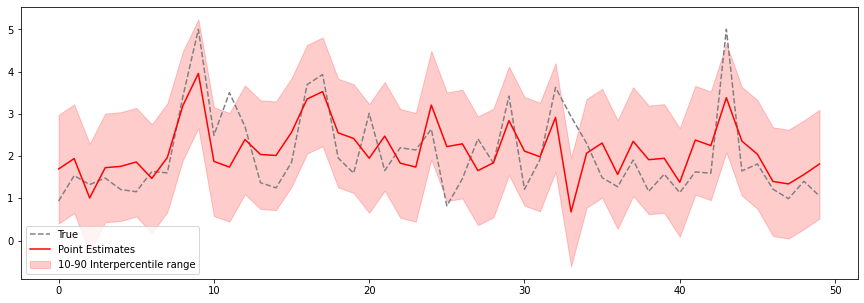

In [20]:
fig, ax = plt.subplots(1, figsize=(15,5))
x = range(ys_true.shape[0])
ax.plot(x, ys_true, "--",  color="grey", label="True")
ax.plot(x, ys_pred, "-",  color="red", label="Point Estimates")
ax.fill_between(x, high, low, color="red", alpha=.2, label="10-90 Interpercentile range")
ax.legend()